## Import Packages

In [1]:
import pandas as pd
import numpy as np
from sklearn.impute import KNNImputer
from sklearn.impute import SimpleImputer
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelEncoder
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer
from sklearn.linear_model import LinearRegression

from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.naive_bayes import GaussianNB
from sklearn.neural_network import MLPClassifier
from sklearn.discriminant_analysis import  LinearDiscriminantAnalysis
from sklearn.preprocessing import MinMaxScaler

from sklearn.metrics import accuracy_score
from sklearn.preprocessing import StandardScaler
from mpl_toolkits.mplot3d import Axes3D
import torch
import torch.nn as nn
from sklearn.model_selection import train_test_split
from sklearn.linear_model import ElasticNet

In [2]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

device(type='cpu')

In [3]:

class Lithology:
    def __init__(self, filename, target_var):
        self.RAND_STATE = 42
        self.df = pd.read_csv(filename, sep=';')
        y = self.df.pop(target_var)
        X = self.df

        obj_cols = X.select_dtypes(include='object').columns.tolist()
        self.encoder = LabelEncoder()
        for col in obj_cols:
            X[col] = self.encoder.fit_transform(X[col])

        self.X_train, self.X_val, self.y_train, self.y_val = train_test_split(X, y, test_size=0.3, random_state=42)
    def knn_impute(self, n_neighbours, X, y):
        # currently KNNImputer takes too long to compute
        knn_imputer = KNNImputer(n_neighbors=n_neighbours)
        imputed_data = knn_imputer.fit_transform(X, y)
        imputed_df = pd.DataFrame(imputed_data, columns=X.columns)
        return imputed_df

    def ffill_impute(self, X):
        return X.ffill(axis=1)

    def simple_impute(self, X, y):
        simple_imputer = SimpleImputer(strategy='mean')
        imputed_data = simple_imputer.fit_transform(X, y)
        imputed_df = pd.DataFrame(imputed_data, columns=X.columns)
        return imputed_df

    def regression_impute(self, X, y):
        imputer = IterativeImputer(estimator=LinearRegression(), max_iter=10, random_state=self.RAND_STATE)
        imputed_df = pd.DataFrame(imputer.fit_transform(X, y), columns=X.columns)
        return imputed_df

    def explore_imputed_data(self):
        ffil_imputed_data, simple_imputed_data, regression_imputed_data = self.ffill_impute(self.X_train),\
            self.simple_impute(self.X_train, self.y_train),\
            self.regression_impute(self.X_train, self.y_train)
        pca = PCA(n_components=3)  # Change to 3 components
        simple_reduced_data = pca.fit_transform(simple_imputed_data, self.y_train)
        ffill_reduced_data = pca.fit_transform(ffil_imputed_data, self.y_train)
        regression_reduced_data = pca.fit_transform(regression_imputed_data, self.y_train)
        # Plot imputed data using dimension reduction
        fig = plt.figure(figsize=(20, 20))
        ax1 = fig.add_subplot(1, 3, 1, projection='3d')
        ax1.scatter(simple_reduced_data[:, 0], simple_reduced_data[:, 1],
                    simple_reduced_data[:, 2], c=self.y_train, s=2)
        ax1.set_title('Simple Imputer')
        ax2 = fig.add_subplot(1, 3, 2, projection='3d')
        ax2.scatter(ffill_reduced_data[:, 0], ffill_reduced_data[:, 1], ffill_reduced_data[:, 2], c=self.y_train, s=2)
        ax2.set_title('ffill Imputer')
        ax3 = fig.add_subplot(1, 3, 3, projection='3d')
        ax3.scatter(regression_reduced_data[:, 0], regression_reduced_data[:, 1], regression_reduced_data[:, 2],
                    c=self.y_train, s=2)
        ax3.set_title('Linear Regression Imputer')
        plt.show()

    def get_important_features(self):
        column_names = ['ffill Imputer', 'simple Imputer', 'regression Imputer']
        important_features_df = pd.DataFrame(columns=column_names)
        for i, X in enumerate(self.ffill_impute(self.X_train),
                              self.simple_impute(self.X_train, self.y_train),
                              self.regression_impute(self.X_train, self.y_train)):
            elasticNet = ElasticNet(alpha=0.1, l1_ratio=0.5, max_iter=10000)
            elasticNet.fit(X, self.y_train)
            coef = pd.Series(elasticNet.coef_, index=X.columns)
            important_features = coef.abs().sort_values(ascending=False)
            important_features_df[column_names[i]] = important_features
        return important_features_df

    def perform_and_evaluate(self, nn_architecture=None):
        models = {
            'logistic_regression': LogisticRegression(random_state=42, max_iter=10000),
            'decision_tree_classifier': DecisionTreeClassifier(random_state=42),
            'random Forrest classifier': RandomForestClassifier(max_depth=100, random_state=42, n_jobs=-1),
            'GaussainNB': GaussianNB(),
            'MLP': MLPClassifier(solver='sgd', activation='tanh', alpha=1e-1, random_state=42, max_iter=10000),
            'LDA': LinearDiscriminantAnalysis()
        }
        results = {}
        for imputer in ['ffill Imputer', 'simple Imputer', 'regression Imputer']:
            if imputer == "ffill Imputer":
                    X_train, X_val = self.ffill_impute(self.X_train), self.ffill_impute(self.X_val)
            elif imputer == "simple Imputer":
                X_train, X_val = self.simple_impute(self.X_train, self.y_train), self.simple_impute(self.X_val, self.y_val)
            elif imputer == "regression Imputer":
                X_train, X_val = self.regression_impute(self.X_train, self.y_train), self.regression_impute(self.X_val, self.y_val)
            else:
                X_train, X_val = 0, 0

            imputer_results = []
            for model_name in models:
                clf = models[model_name]
                clf.fit(X_train, self.y_train)
                y_pred = clf.predict(X_val)
                imputer_results.append(accuracy_score(self.y_val, y_pred))
            results[imputer] = imputer_results

        return pd.DataFrame.from_dict(results, orient='index', columns=[model_name for model_name in models])



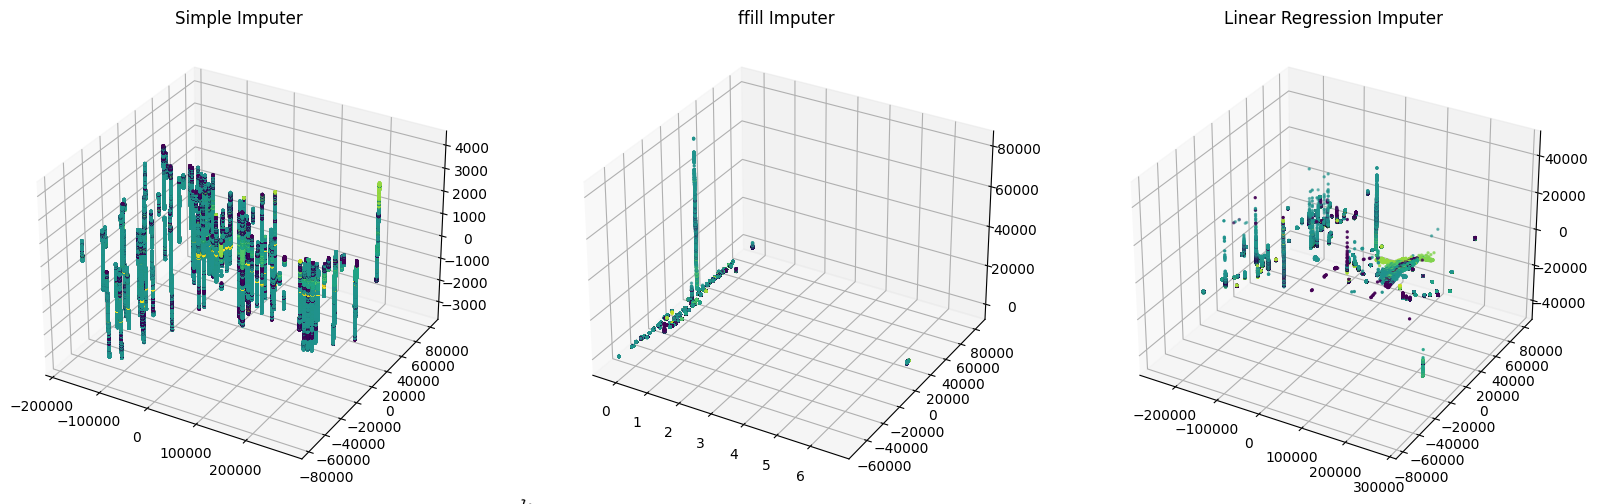

In [4]:
l = Lithology(filename='./train/train.csv', target_var='FORCE_2020_LITHOFACIES_LITHOLOGY')
l.explore_imputed_data()

In [5]:
validation_scores = l.perform_and_evaluate()
validation_scores

,logistic_regression,decision_tree_classifier,random Forrest classifier,GaussainNB,MLP,LDA
ffill Imputer,0.617023,0.926377,0.956364,0.088346,0.619213,0.670085
simple Imputer,0.615311,0.907271,0.958531,0.181479,0.615311,0.710873
regression Imputer,0.615434,0.765083,0.938585,0.233875,0.615311,0.704981


After training the data and evalauting the validation dataset, our best method will be to predict the test set with the random forrest classifier with the simple Imputer